In [15]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),#Konverterer billederne til Pytorch tensors
    transforms.Normalize((0.5,), (0.5,))]) #Normaliserer/gør dataen mindre ved brug af mean (gennemsnittet)

# datasets 
trainset = torchvision.datasets.FashionMNIST('./data', # Trainset peger på, hvilket root til mappen den skal gemmes til
    download=True, # Download hvis True, downloader datasættet fra internettet og sætter den i rodmappen Hvis datasættet allerede er downloadet, downloades det ikke igen.
    train=True, # Dette dataset er sat til true i det skal bruges til trænigns sættet 
    transform=transform # En funktion/transformation, der tager et PIL-billede ind og returnerer en transformeret version 
    ) 
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

    
# dataloaders

#Dataloader klassen tager imod  træningsættet, batch_size, shuffle og num_workers som argument

#Trainset er træningsættet vi bruger, i dette tilfælde fra en eksisterende træningsæt fra fashionmnist

#Batch_size er antallet af prøver for hvergang man træner sin model. I dette tilfælde er det 4 billeder man træner af gangen

#Shuffle er når man blander værdierne i datasættet

#Numworkers fortæller dataloader hvor mange sub-processer der skal bruges i forbindelse med loading af dat
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=0)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=0)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel: #Der er kun en kanal
        img = img.mean(dim=0)
    img = img / 2 + 0.5  #unnormalize, for at få den tilbage til den oprindelige til det neurale netværk (der kan godt udkommenteres)
    npimg = img.numpy()
    if one_channel: #Hvis der kun er en kanal blier det grå billeder 
        plt.imshow(npimg, cmap="Greys")
    else: #Hvis der er flere kanaler bliver det favet billeder 
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) #(2D Convolution Layer)
        self.pool = nn.MaxPool2d(2, 2) #Reducerer antal pixels ved at tage det højest inden for feltet 2x2
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [17]:
criterion = nn.CrossEntropyLoss() #Bliver brugt til classification Logits --> softmax --> out probabilities opdeling i classes
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 
#lr En Tensor der ikke tager nogen argumenter og returnerer den faktiske værdi, der skal bruges. Indlæringshastigheden. Standard er 0,01. 
# momentum hjælper med at accelerere gradientvektorer i de rigtige retninger, hvilket fører til hurtigere konvergering

In [18]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1') 
# smider log_dir filerne over til runs mappen som bliver lavet og brugt til outputet i næste trin



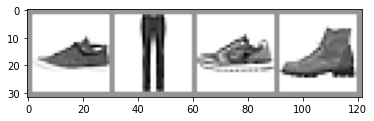

In [19]:
# get some random training images
dataiter = iter(trainloader) #Thomas
images, labels = dataiter.next()

writer.add_graph(net, images)


# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)
writer.close()

In [20]:
# Look at training curves in tensorboard:
%load_ext tensorboard 
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 10860), started 0:15:56 ago. (Use '!kill 10860' to kill it.)

In [21]:
# helper function
def select_n_random(data, labels, n=100): #Yusuf
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

In [25]:
# helper functions

def images_to_probs(net, images): 
    '''
    Genererer forudsigelser og tilsvarende sandsynligheder fra en trænet
     netværk og en liste over billeder
    '''
    output = net(images)
    # konvertere output sandsynligheder til forudsagt klasse
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) #Fjerner enkeltdimensionelle indgange fra formen af et array
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]
    # softmax konverterer en vektor af tal til en vektor af sandsynligheder, hvor sandsynligheden for hver værdi er proportional med den relative skala af hver værdi i vektoren. 
    #Zip()-funktionen tager iterables (kan være nul eller flere), samler dem i en tupel og returnerer den


def plot_classes_preds(net, images, labels):
    '''
    Genererer matplotlib-figur ved hjælp af et trænet netværk sammen med billeder
     og etiketter fra en batch, der viser netværkets bedste forudsigelse
     med dens sandsynlighed, sammen med den faktiske etiket, farve denne
     information baseret på, om forudsigelsen var korrekt eller ej.
     Bruger funktionen "images_to_probs".
    '''
    preds, probs = images_to_probs(net, images)
    # plot billederne i batchen sammen med forudsagte og sande etiketter
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
                    #Den sammenligner sandsynligheden med billederne og labels 
                    #grøn jo mere sandsynlig den er og rød hvis den er mindre sandsynlig kan ses når vi køre koden

    return fig

In [23]:
running_loss = 0.0 #Thomas
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


In [24]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = [] #Yusuf
class_label = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)